<a href="https://colab.research.google.com/github/steve-shim/dlgom/blob/main/deeplearning/%EA%B2%80%EC%A6%9D%EB%8D%B0%EC%9D%B4%ED%84%B0%2B%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

In [62]:
x = cancer.data
y = cancer.target
print(x.shape, y.shape)

(569, 30) (569,)


In [63]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify=y,
                                                            test_size=0.2, random_state=42)
print(x_train_all.shape, x_test.shape) 
# test 114개 데이터는 학습하는데 안쓴다 (실전투입전 최종점검용)

(455, 30) (114, 30)


In [64]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all, test_size=0.2, random_state=42)
print(x_train.shape, x_val.shape) 
# 훈련데이터 364개 데이터는 모델파라미터 튜닝
# 검증데이터 91개 데이터는 하이퍼파라미터 튜닝 (모델을 튜닝하려면 성능 점수가 필요하다)
# 테스트 데이터는 모델 튜닝을 모두 마치고 실전에 투입하기 전에 딱 한번만 사용

(364, 30) (91, 30)


['mean perimeter' 'mean area']


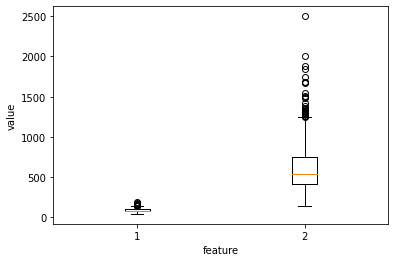

In [65]:
import matplotlib.pyplot as plt
import numpy as np

print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [66]:
# 단일층 신경망 클래스

class SingleLayer:

  def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.w_history = []
    self.lr = learning_rate

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b
    return z

  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))
    return a
  
  def fit(self, x, y, epochs=100): # X: (364,30), y: (364,)
    self.w = np.ones(x.shape[1])   # 샘플의 특성의 갯수만큼 가중치 초기화
    self.b = 0
    self.w_history.append(self.w.copy()) # 훈련을 시작하기전 초기화된 가중치 기록
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # X배열 자체를 섞지않고 X의 길이의 인덱스 배열을 섞는다 (0~454)
      # SGD(확률적 경사하강법)은 epochs 마다 전체 샘플을 섞어준다 
      for i in indexes:
        z = self.forpass(x[i])  # (30,) -> 선형회귀값 하나 출력
        a = self.activation(z)  # 양성클래스 예측값 하나 출력
        err = -(y[i] - a)       # 샘플마다 err 값이 하나 출력
        w_grad, b_grad = self.backprop(x[i], err) # err 값 하나로 특성 30개의 그라디언트를 계산
        self.w -= self.lr * w_grad        # 샘플 하나로 특성 30개의 가중치 업데이트 
        self.b -= b_grad
        # 업데이트된 가중치 기록
        self.w_history.append(self.w.copy())
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a)) # 샘플마다 정답과의 차이인 오차를 누적하고
      self.losses.append(loss/len(y))                  # 에포크마다 평균 손실을 저장 
    
  def predict(self, x):                  # 2. x: (91, 30)
    z = [self.forpass(x_i) for x_i in x] 
    return np.array(z) > 0               # 3. (91,)

  def score(self, x, y):                  # 1. x: (91, 30), y: (91,)
    return np.mean(self.predict(x) == y)  # 4. np.mean( (91,) == (91,) )


In [67]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

In [68]:
print(x_train.shape)
print(type(layer1.w_history))
print(type(layer1.w_history[0]))
print(layer1.w_history[0].shape)
print(len(layer1.w_history)) # 맨처음 가중치 값 + epochs(100) x 훈련샘플수(364)


(364, 30)
<class 'list'>
<class 'numpy.ndarray'>
(30,)
36401


In [69]:
layer1.w_history[0].shape

(30,)

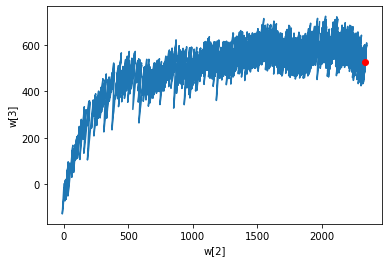

In [70]:
# 3번째, 4번째 특성의 가중치 변화 시각화
w2=[]
w3=[]
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

특성 30개를 표준화를 통해서 스케일을 일치시키고 학습할 때

훈련데이터의 평균, 표준편차를 검정데이터에도 적용해야한다

In [71]:
train_mean = np.mean(x_train, axis=0) # (30,)
train_std = np.std(x_train, axis=0)   # (30,)
x_train_scaled = (x_train - train_mean) / train_std # (364, 30)
x_val_scaled = (x_val - train_mean) / train_std     # (91, 30)

특성의 스케일을 비슷하게 맞추면 최적의 가중치 값에 빠르게 근접한다

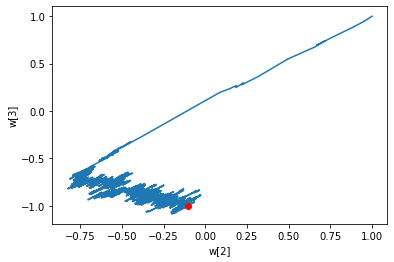

In [72]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2=[]
w3=[]
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

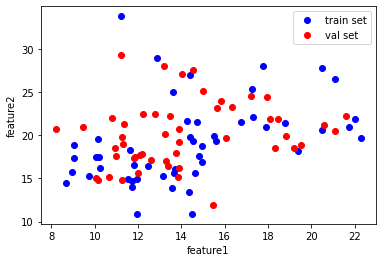

In [73]:
plt.plot(x_train[:50,0], x_train[:50,1], 'bo')
plt.plot(x_val[:50,0], x_val[:50,1], 'ro')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend(['train set', 'val set'])
plt.show()

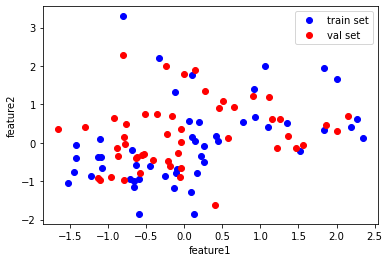

In [74]:
# 데이터를 제대로 전처리했다면 훈련세트와 검증세트의 거리가 그대로 유지되어야 한다.

plt.plot(x_train_scaled[:50,0], x_train_scaled[:50,1], 'bo')
plt.plot(x_val_scaled[:50,0], x_val_scaled[:50,1], 'ro')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend(['train set', 'val set'])
plt.show()

In [75]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

과소적합된 모델 -> 편향되었다

과대적합된 모델 -> 분산이 크다

In [76]:
# 단일층 신경망 클래스 + 검증손실까지 기록

class SingleLayer:

  def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []      # list안에 (30,)배열을 100 x 364 + 1 개 가지고 있다
    self.lr = learning_rate

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b
    return z

  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))
    return a
  
  def fit(self, x, y, epochs=100, x_val=None, y_val=None): # X: (364,30), y: (364,)
    self.w = np.ones(x.shape[1])   # 샘플의 특성의 갯수만큼 가중치 초기화
    self.b = 0
    self.w_history.append(self.w.copy()) # 훈련을 시작하기전 초기화된 가중치 기록
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # X배열 자체를 섞지않고 X의 길이의 인덱스 배열을 섞는다 (0~454)
      # SGD(확률적 경사하강법)은 epochs 마다 전체 샘플을 섞어준다 
      for i in indexes:
        z = self.forpass(x[i])  # (30,) -> 선형회귀값 하나 출력
        a = self.activation(z)  # 양성클래스 예측값 하나 출력
        err = -(y[i] - a)       # 샘플마다 err 값이 하나 출력
        w_grad, b_grad = self.backprop(x[i], err) # err 값 하나로 특성 30개의 그라디언트를 계산
        self.w -= self.lr * w_grad        # 샘플 하나로 특성 30개의 가중치 업데이트 
        self.b -= b_grad
        # 업데이트된 가중치 기록
        self.w_history.append(self.w.copy())
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a)) # 샘플마다 정답과의 차이인 오차를 누적하고
      self.losses.append(loss/len(y))                  # 에포크마다 평균 손실을 저장 
      self.update_val_loss(x_val, y_val)               # 에포크마다 검증 세트에 대한 손실을 계산
    
  def predict(self, x):                  # 2. x: (91, 30)
    z = [self.forpass(x_i) for x_i in x] 
    return np.array(z) > 0               # 3. (91,)

  def score(self, x, y):                  # 1. x: (91, 30), y: (91,)
    return np.mean(self.predict(x) == y)  # 4. np.mean( (91,) == (91,) )

  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
    self.val_losses.append(val_loss/len(y_val))


In [77]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

In [78]:
layer3.score(x_val_scaled, y_val)

0.967032967032967

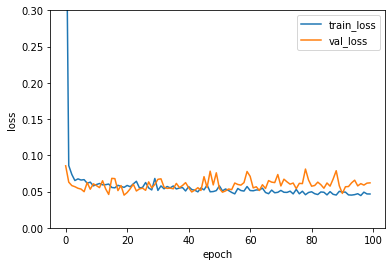

In [79]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

train_loss 와 val_loss 를 비교해서 과적합이 일어나지 않는 최적의 epoch(20)을 찾는다

In [80]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.978021978021978

**가중치 규제의 효과**

규제가 강해지면 -> 과소적합된 모델 가능성

규제가 약해지면 -> 과대적합된 모델 가능성

In [81]:
# 단일층 신경망 클래스

class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []      # list안에 (30,)배열을 100 x 364 + 1 개 가지고 있다
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b
    return z

  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))
    return a
  
  def fit(self, x, y, epochs=100, x_val=None, y_val=None): # X: (364,30), y: (364,)
    self.w = np.ones(x.shape[1])   # 샘플의 특성의 갯수만큼 가중치 초기화
    self.b = 0
    self.w_history.append(self.w.copy()) # 훈련을 시작하기전 초기화된 가중치 기록
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # X배열 자체를 섞지않고 X의 길이의 인덱스 배열을 섞는다 (0~454)
      # SGD(확률적 경사하강법)은 epochs 마다 전체 샘플을 섞어준다 
      for i in indexes:
        z = self.forpass(x[i])  # (30,) -> 선형회귀값 하나 출력
        a = self.activation(z)  # 양성클래스 예측값 하나 출력
        err = -(y[i] - a)       # 샘플마다 err 값이 하나 출력
        w_grad, b_grad = self.backprop(x[i], err) # err 값 하나로 특성 30개의 그라디언트를 계산
        # 그레이디언트에서 페널티 항의 미분값을 더한다
        w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
        self.w -= self.lr * w_grad        # 샘플 하나로 특성 30개의 가중치 업데이트 
        self.b -= b_grad
        # 업데이트된 가중치 기록
        self.w_history.append(self.w.copy())
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))   # 샘플마다 정답과의 차이인 오차를 누적하고
      self.losses.append(loss/len(y) + self.reg_loss())  # 에포크마다 평균 손실을 저장 
      self.update_val_loss(x_val, y_val)                 # 에포크마다 검증 세트에 대한 손실을 계산
    
  def reg_loss(self):  # 훈련세트의 로지스틱 손실함수의 값과 검증세트의 로지스틱 손실함수의 값을 계산할 때 모두 호출
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2) 
  
  def predict(self, x):                  # 2. x: (91, 30)
    z = [self.forpass(x_i) for x_i in x] 
    return np.array(z) > 0               # 3. (91,)

  def score(self, x, y):                  # 1. x: (91, 30), y: (91,)
    return np.mean(self.predict(x) == y)  # 4. np.mean( (91,) == (91,) )

  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
    self.val_losses.append(val_loss/len(y_val) + self.reg_loss())


L1 규제 적용

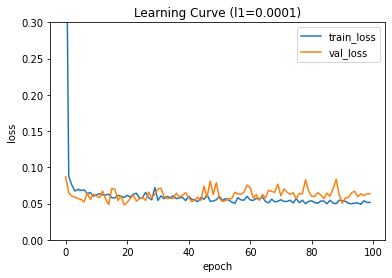

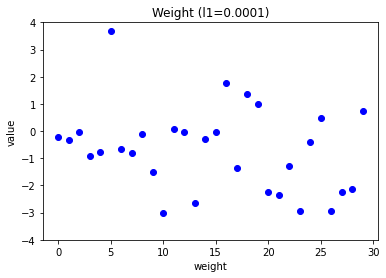

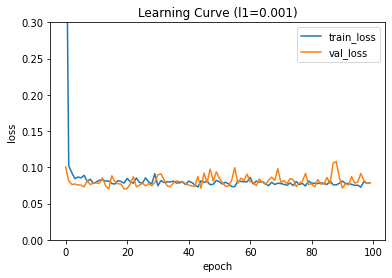

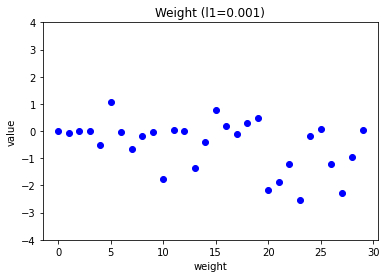

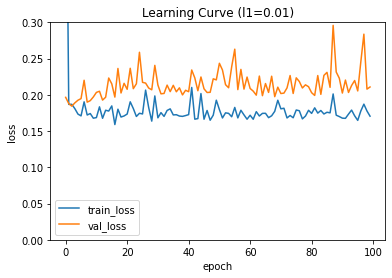

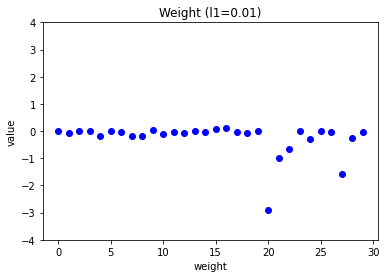

In [82]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
  lyr = SingleLayer(l1=l1)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses, label='train_loss')
  plt.plot(lyr.val_losses, label='val_loss')
  plt.title('Learning Curve (l1={})'.format(l1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l1={})'.format(l1))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

규제가 너무 없으면 일찍 과대적합이 발생한다

규제가 적당하면 일정 에포크동안 과대적합없이 안정적으로 학습이 진행되고 (가중치 값들이 너무 커지지 않게 규제가 들어간다) 

규제가 더 커질수록 훈련세트의 손실과 검증세트의 손실이 모두 높아진다 (과소적합)

특히 l1의 규제강도가 커질수록 가중치의 값이 0에 가까워진다

In [83]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

0.978021978021978

L2 규제 적용

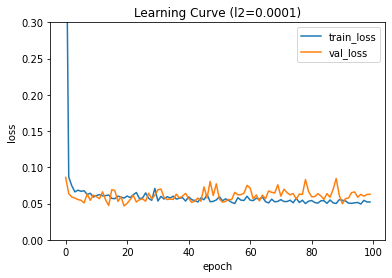

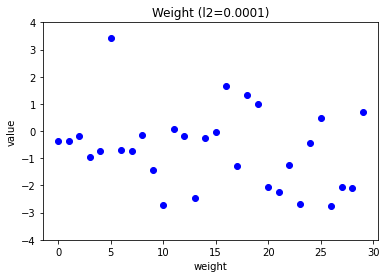

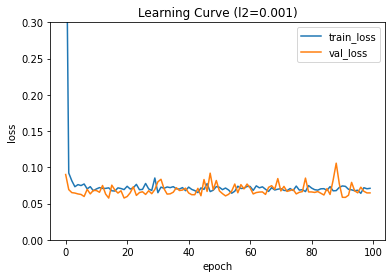

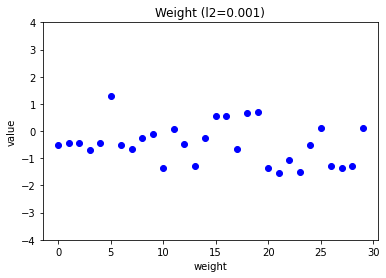

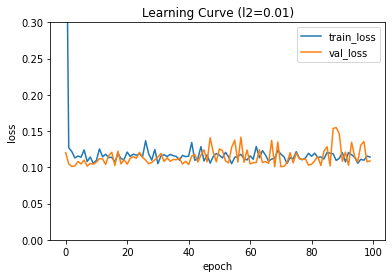

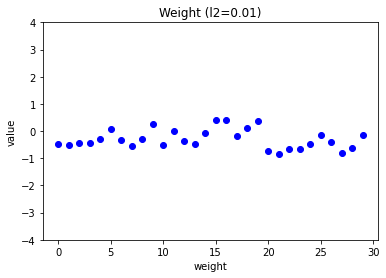

In [84]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
  lyr = SingleLayer(l2=l2)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses, label='train_loss')
  plt.plot(lyr.val_losses, label='val_loss')
  plt.title('Learning Curve (l2={})'.format(l2))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l2={})'.format(l2))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4,4)
  plt.show()

L2 규제는 규제강도가 강해져도 L1 규제만큼 과소적합이 심해지지는 않는다 

가중치 그래프를 보아도 가중치가 0에 너무 가깝게 줄어들지 않는다

In [85]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.978021978021978

In [86]:
x_val_scaled.shape

(91, 30)

In [87]:
np.sum(layer6.predict(x_val_scaled) == y_val)
# 91개의 검증 샘플 중 89개의 샘플을 올바르게 예측

89

In [88]:
layer6.predict(x_val_scaled) == y_val

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True])

In [89]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

k-폴드 교차 검증 구현

In [90]:
print(x_train_all.shape)
print(y_train_all.shape)

(455, 30)
(455,)


In [91]:
x_train_all[45:90].shape

(45, 30)

검증폴드가 전처리 단계에서 누설되면 안 되기 때문에 **폴드를 나눈 후에 훈련 폴드의 통계치(평균, 표준편차)로 검증 폴드를 전처리한다**.

In [92]:
validation_scores = []

k = 10
bins = len(x_train_all) // k  
# 455 // 10 = 45 (샘플 455개를 10등분하여 45개 x 10 으로 쪼갠다)

for i in range(k): # bins 만큼 10번 수행한다
  start = i*bins
  end = (i+1)*bins
  val_fold = x_train_all[start:end] # 10개로 나눈 덩어리중 한 덩어리를 검증데이터로 사용하고
  val_target = y_train_all[start:end] # 나머지 9덩어리와 남은 데이터들을 이용하여 훈련데이터로 사용한다

  train_index = list(range(0,start)) + list(range(end, len(x_train_all)))
  # print(len(train_index)) # 455개의 샘플에서 검증데이터 45개를 뺀 410개의 인덱스를 가지고 훈련데이터로 사용한다
  train_fold = x_train_all[train_index]   # (410, 30)
  train_target = y_train_all[train_index] # (410,)
  
  train_mean = np.mean(train_fold, axis=0) # (30,)
  train_std = np.std(train_fold, axis=0)   # (30,)
  train_fold_scaled = (train_fold - train_mean) / train_std  
  val_fold_scaled = (val_fold - train_mean) / train_std      # 검증데이터를 뺀 훈련데이터의 평균,표준편차로 검증데이터를 표준화 진행해야한다 

  lyr = SingleLayer(l2=0.01)
  lyr.fit(train_fold_scaled, train_target, epochs=50)
  score = lyr.score(val_fold_scaled, val_target)
  validation_scores.append(score)

print(validation_scores) # 교차검증을 10번을 수행하고 수행했을때마다 교차점수를 리스트에 저장해둔다
                         # [0.933, 0.977, 0.955, 0.977, 0.955, 1.0, 0.955, 1.0, 1.0, 0.955]
print(np.mean(validation_scores)) # 0.971

[0.9333333333333333, 0.9777777777777777, 0.9555555555555556, 0.9777777777777777, 0.9555555555555556, 1.0, 0.9555555555555556, 1.0, 1.0, 0.9555555555555556]
0.9711111111111113


**<데이터 전처리 없이 교차검증을 수행했을 때>**

In [93]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10, return_train_score=True)

print("훈련폴드의 평균점수:", np.mean(scores['train_score']))
print("검증폴드의 평균점수:", np.mean(scores['test_score']))

훈련폴드의 평균점수: 0.8515582324527401
검증폴드의 평균점수: 0.850096618357488


**<데이터 전처리 + 교차검증 수행했을 때>**

전처리를 하고 교차검증에 넣는게 아니고 교차검증하는 서로 다른 폴드마다 전처리를 해야하기 때문에 교차검증 안에 전처리과정이 들어가야한다

In [94]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd) # 전처리객체와 모델객체를 묶어서 하나의 객체로 만든다 (아직 어떤 데이터를 전처리해야하는지 모른다) 
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True) # 검증세트를 따로 나누지 않고 훈련세트 전체를 사용한다 
                                                       # 이때 비로소 cv=10 으로 나뉜 훈련데이터들을 이용해서 전처리를하고 모델 훈련을 진행한다 
print("훈련폴드의 평균점수:", np.mean(scores['train_score']))
print("검증폴드의 평균점수:", np.mean(scores['test_score']))

훈련폴드의 평균점수: 0.9875478561631581
검증폴드의 평균점수: 0.9694202898550724


In [95]:
scores

{'fit_time': array([0.01612329, 0.00481606, 0.00479174, 0.00556302, 0.00414848,
        0.00499058, 0.00503325, 0.00526071, 0.00560999, 0.00456643]),
 'score_time': array([0.00089622, 0.00063729, 0.00059223, 0.00063276, 0.0005703 ,
        0.00060821, 0.00077629, 0.00066996, 0.00074005, 0.00084066]),
 'test_score': array([0.93478261, 0.95652174, 1.        , 0.95652174, 0.91304348,
        1.        , 1.        , 1.        , 1.        , 0.93333333]),
 'train_score': array([0.99266504, 0.98777506, 0.99022005, 0.98777506, 0.98777506,
        0.98536585, 0.98536585, 0.98780488, 0.98292683, 0.98780488])}